**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import gc
import cv2
import numpy as np

import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from torch.utils.data import Dataset
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

from torchmetrics.functional import jaccard_index

%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
            
        augmented = self.transform(image=image,
                                   mask=mask)
        sample = {}
        sample['image'] = augmented['image']
        sample['mask'] = augmented['mask']

        return sample

In [3]:
X_train = get_paths("./data/train/images")
y_train = get_paths("./data/train/gt")

X_test = get_paths("./data/test/images")
y_test = get_paths("./data/test/gt")

train_transform = A.Compose([
    A.HorizontalFlip(),
    A.RandomRotate90(),
    A.RandomGamma(p=0.5),
#     A.ColorJitter(p=0.5),
    A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
    ], p=0.15),
    A.PadIfNeeded(min_height=512, min_width=512),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512),
    ToTensorV2(),
])

In [4]:
train_dataset = RoadDataset(X_train, y_train, train_transform)
test_dataset = RoadDataset(X_test, y_test, test_transform)

torch.Size([3, 512, 512]) torch.Size([512, 512])


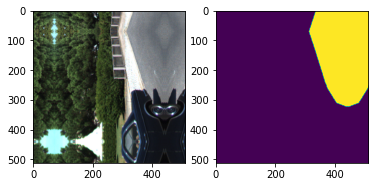

In [5]:
sample = train_dataset[4]
image = sample['image']
mask = sample['mask']

print(image.shape, mask.shape)
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [6]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [8]:
def calc_dice(pred, target, alpha = 0.75):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    dice = (2 * intersection + alpha) / (pred.sum() + target.sum() + alpha) 
    
    return dice

def calc_focal(pred, target, alpha=0.8, gamma=2, smooth=1):  
    pred = pred.view(-1)
    target = target.view(-1)

    BCE = F.binary_cross_entropy(pred, target, reduction='mean')
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha * (1 - BCE_EXP) ** gamma * BCE

    return focal_loss

def calc_loss(pred, target):
#     weights = torch.eye(target.shape[0]) * 1 + 1
    
#     bce_loss = F.binary_cross_entropy(pred, target.unsqueeze(1), 
#                                                   weight=weights.to(device)
#                                                  )
    dice_loss = 1 - calc_dice(pred, target)
    focal_loss = calc_focal(pred, target)
    
    loss = focal_loss + dice_loss
    
    
    
    return loss

In [9]:
BATCH_SIZE = 9

### Model U-Net

In [28]:
class ConvLayer(nn.Module):
    
    def __init__(self, input_channels, output_channels, mid_channels=None, padding='same'):
        super().__init__()
        
        if mid_channels is None:
            mid_channels = output_channels
            
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                               out_channels=mid_channels,
                               kernel_size=(3, 3),
                               padding=padding,
                               dilation=2,
                               bias=False)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, 
                               out_channels=output_channels,
                               kernel_size=(3, 3),
                               padding=padding,
                               dilation=2,
                               bias=False)
        
        self.dropout = nn.Dropout(0.15)
        self.use_dropout = False
        
        self.batchnorm1 = nn.BatchNorm2d(num_features=output_channels)
        self.batchnorm2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        
        if self.use_dropout:
            x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        
        
        return x

In [11]:
class DownScaller(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_layer = ConvLayer(input_channels, output_channels)
    
    def forward(self, input):
        x = self.maxpool(input)
        x = self.conv_layer(x)

        return x

In [12]:
class UpScaler(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv_transposed = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=2, stride=2)
        self.conv_layer = ConvLayer(input_channels, output_channels, input_channels // 2)
           
    def forward(self, x1, x2):
        x1 = self.conv_transposed(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv_layer(x)
        
        return x
        

In [13]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
                
        self.input_channel = 3
        self.output_channel = 16
        self.n_classes = 1
        
        self.conv1 = ConvLayer(self.input_channel, self.output_channel)
        
        self.down1 = DownScaller(self.output_channel * 1, self.output_channel * 2)
        self.down2 = DownScaller(self.output_channel * 2, self.output_channel * 4)
        self.down3 = DownScaller(self.output_channel * 4, self.output_channel * 8)
        self.down4 = DownScaller(self.output_channel * 8, self.output_channel * 16)
        self.down5 = DownScaller(self.output_channel * 16, self.output_channel * 32)
        
        self.up1 = UpScaler(self.output_channel * 32, self.output_channel * 16)
        self.up2 = UpScaler(self.output_channel * 16, self.output_channel * 8)
        self.up3 = UpScaler(self.output_channel * 8, self.output_channel * 4)
        self.up4 = UpScaler(self.output_channel * 4, self.output_channel * 2)
        self.up5 = UpScaler(self.output_channel * 2, self.output_channel * 1)

        self.conv3 = nn.Conv2d(self.output_channel * 1, self.n_classes, kernel_size=(3, 3), padding='same')
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self, input):
               
        x_1 = self.conv1(input)
        x_2 = self.down1(x_1)
        x_3 = self.down2(x_2)
        x_4 = self.down3(x_3)
        x_5 = self.down4(x_4)
        x_6 = self.down5(x_5)

        x_7 = self.up1(x_6, x_5)
        x_8 = self.up2(x_7, x_4)      
        x_9 = self.up3(x_8, x_3)
        x_10 = self.up4(x_9, x_2)
        x_11 = self.up5(x_10, x_1)
        
        output = self.conv3(x_11)
        output = self.sigmoid(output)
        
        return output

In [14]:
# CHECK
unet = UNet()
a = torch.rand([4, 3, 512, 512])
out = unet(a)

print(out.shape)

torch.Size([4, 1, 512, 512])


### Train U-Net

In [14]:
EPOCHS = 5
learning_rate = 0.001

In [15]:
# model = UNet().to(device)
# summary(model, input_size=train_dataset[0]['image'].shape)

In [14]:
def train_model(model, data_loader, optimizer, epoch):
    loss_history = []
    iou_history = []
    acc_history = []
    
    for i, batch in enumerate(tqdm(data_loader, desc='TRAIN')):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        loss.backward()
           
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history.append(loss.item())
        iou_history.append(jaccard_index(output, y_batch.int(), num_classes=2).cpu().detach().numpy())
        
          
        writer.add_scalars('Train', 
                   {'Loss': loss_history[-1], 'IoU': iou_history[-1]}, 
                   i + epoch * len(train_dataset) // BATCH_SIZE)
        
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}' )
    
    return model

In [15]:
@torch.no_grad()
def eval_model(model, data_loader, scheduler, epoch):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(tqdm(data_loader, desc='VALID')):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        
        loss_history.append(loss.item() )
        iou_history.append(jaccard_index(output, y_batch.int(), num_classes=2).cpu().detach().numpy())
        
        writer.add_scalars('Valid', 
                           {'Loss': loss_history[-1], 'IoU': iou_history[-1]}, 
                           i + epoch * len(test_dataset) // BATCH_SIZE)
    
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}')

In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter(comment='_test2')

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=.75, verbose=True)

for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
    
    model.train(True) 
    model = train_model(model, train_loader, optimizer, epoch)
    
    model.train(False) 
    eval_model(model, test_loader, scheduler, epoch)
    
    scheduler.step()
    torch.cuda.empty_cache()

In [22]:
@torch.no_grad()
def score_dataset(model, dataset):
    
    iou = 0 
    for idx in tqdm(range(len(dataset))):
        sample = dataset[idx]
        x_batch, y_batch = sample['image'].to(device).float(), sample['mask'].to(device).int()
        
        output = model(x_batch[None, ...])
        iou += jaccard_index(output, y_batch, num_classes=2).cpu().detach().numpy()
        
    print(f"IoU: {iou / len(dataset):.3f}")

In [23]:
def visualize(model):
    random_img_count = 5
    random_test_idx = np.random.choice(list(range(len(test_dataset))), size=random_img_count, replace=False)

    for idx in random_test_idx:
        sample = test_dataset[idx]
        image, mask = sample['image'].to(device).float(), sample['mask'].to(device)
        pred_mask = model(image[None, :, :, :])

        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(image.cpu().permute(1, 2, 0))
        plt.subplot(1, 3, 2)
        plt.title('Prediction mask')
        plt.imshow(pred_mask.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.subplot(1, 3, 3)
        plt.title('GT')
        plt.imshow(mask.cpu().detach().numpy())
        plt.show()

In [ ]:
score_dataset(model, train_dataset)

In [ ]:
score_dataset(model, test_dataset)

In [ ]:
visualize(model)

In [ ]:
# torch.save(model, './models/custom_unet.pth')

model = torch.load('./models/custom_unet.pth')

## Unet with pretrained backbone

In [ ]:
summary(backbone, (3, 512, 512))

In [16]:
def calc_dice(pred, target, alpha = 1):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    dice = (2 * intersection + alpha) / (pred.sum() + target.sum() + alpha) 
    
    return dice

def calc_focal(pred, target, alpha=0.8, gamma=3, smooth=1):  
    pred = pred.view(-1)
    target = target.view(-1)

    BCE = F.binary_cross_entropy(pred, target, reduction='mean')
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha * (1 - BCE_EXP) ** gamma * BCE

    return focal_loss

def calc_loss(pred, target):
#     weights = torch.eye(target.shape[0]) * 1 + 1
    
#     bce_loss = F.binary_cross_entropy(pred, target.unsqueeze(1), 
#                                                   weight=weights.to(device)
#                                                  )
    dice_loss = 1 - calc_dice(pred, target)
    focal_loss = calc_focal(pred, target)
    
    loss = focal_loss + dice_loss
    
    return loss

In [29]:
class UNet_ResNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.backbone = torchvision.models.resnet18(pretrained=True).to(device)
        
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        self.up1 = UpScaler(512, 256)
        self.up2 = UpScaler(256, 128)
        self.up3 = UpScaler(128, 64)
        self.up4 = UpScaler(64, 32)
        self.up5 = UpScaler(32, 16)
        
        self.conv_x_1 = nn.Conv2d(64, 32, (3, 3), padding='same', bias=False)
        self.bn_x_1 = nn.BatchNorm2d(32)
        
        self.conv_out = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        self.sigmoid = nn.Sigmoid()
        
        self.conv1 = nn.Conv2d(3, 64, (3, 3), padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 16, (3, 3), padding='same', bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        
    def forward(self, input):
        
        # input
        x_input = self.conv1(input)
        x_input = self.bn1(x_input)
        x_input = F.relu(x_input)
        x_input = self.conv2(x_input)
        x_input = self.bn2(x_input)
        x_input = F.relu(x_input)
        
        # Encoder
        x_1 = self.backbone.conv1(input)
        x_1 = self.backbone.bn1(x_1)
        x_1 = self.backbone.relu(x_1)
        x_2 = self.backbone.maxpool(x_1)
        x_2 = self.backbone.layer1(x_2)
        x_3 = self.backbone.layer2(x_2)
        x_4 = self.backbone.layer3(x_3)
        x_5 = self.backbone.layer4(x_4)
        
        # Decoder
        x_6 = self.up1(x_5, x_4)
        x_7 = self.up2(x_6, x_3)
        x_8 = self.up3(x_7, x_2)
        
        x_1_res = self.conv_x_1(x_1)
        x_1_res = self.bn_x_1(x_1_res)
        x_1_res = F.relu(x_1_res)
        x_9 = self.up4(x_8, x_1_res) 
        
        x_10 = self.up5(x_9, x_input)
        
        output = self.conv_out(x_10)
        output = self.sigmoid(output)
        
        return output

In [30]:
# model = UNet_ResNet().to(device)
# summary(model, input_size=train_dataset[0]['image'].shape)

In [31]:
learning_rate = 0.0005
EPOCHS = 12

In [32]:
model = UNet_ResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter(comment='_test2')

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=.75, verbose=True)

for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
    
    model.train(True) 
    model = train_model(model, train_loader, optimizer, epoch)
    
    model.train(False) 
    eval_model(model, test_loader, scheduler, epoch)
    
#     scheduler.step()
    torch.cuda.empty_cache()

Adjusting learning rate of group 0 to 5.0000e-04.


EPOCH:   0%|          | 0/12 [00:00<?, ?it/s]

-------------------------------------------------- Epoch 1 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.363 ± 0.150            IoU: 0.786  ± 0.099


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.313 ± 0.224            IoU: 0.821  ± 0.110
-------------------------------------------------- Epoch 2 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.177 ± 0.057            IoU: 0.843  ± 0.052


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.243 ± 0.223            IoU: 0.806  ± 0.132
-------------------------------------------------- Epoch 3 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.146 ± 0.066            IoU: 0.856  ± 0.058


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.191 ± 0.188            IoU: 0.838  ± 0.114
-------------------------------------------------- Epoch 4 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.130 ± 0.053            IoU: 0.864  ± 0.049


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.179 ± 0.169            IoU: 0.845  ± 0.104
-------------------------------------------------- Epoch 5 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.118 ± 0.048            IoU: 0.873  ± 0.044


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.166 ± 0.155            IoU: 0.851  ± 0.093
-------------------------------------------------- Epoch 6 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.117 ± 0.051            IoU: 0.874  ± 0.046


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.167 ± 0.167            IoU: 0.851  ± 0.097
-------------------------------------------------- Epoch 7 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.100 ± 0.055            IoU: 0.891  ± 0.048


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.169 ± 0.167            IoU: 0.847  ± 0.091
-------------------------------------------------- Epoch 8 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.108 ± 0.069            IoU: 0.884  ± 0.052


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.154 ± 0.157            IoU: 0.861  ± 0.089
-------------------------------------------------- Epoch 9 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.088 ± 0.043            IoU: 0.902  ± 0.040


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.142 ± 0.131            IoU: 0.867  ± 0.085
-------------------------------------------------- Epoch 10 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.088 ± 0.037            IoU: 0.901  ± 0.034


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.140 ± 0.117            IoU: 0.865  ± 0.078
-------------------------------------------------- Epoch 11 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.086 ± 0.045            IoU: 0.904  ± 0.041


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.140 ± 0.118            IoU: 0.865  ± 0.081
-------------------------------------------------- Epoch 12 / 12 --------------------------------------------------


TRAIN:   0%|          | 0/72 [00:00<?, ?it/s]

Loss: 0.082 ± 0.036            IoU: 0.906  ± 0.035


VALID:   0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.138 ± 0.147            IoU: 0.872  ± 0.086


In [33]:
score_dataset(model, train_dataset)

  0%|          | 0/648 [00:00<?, ?it/s]

IoU: 0.878


In [34]:
score_dataset(model, test_dataset)

  0%|          | 0/219 [00:00<?, ?it/s]

IoU: 0.862


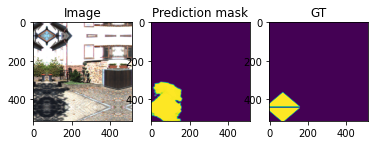

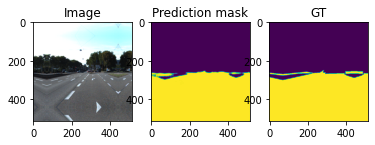

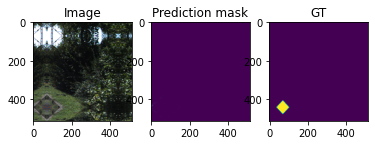

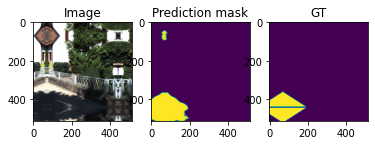

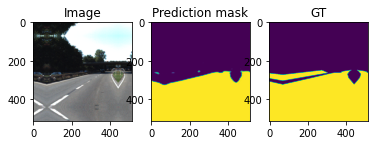

In [35]:
visualize(model)

In [36]:
# torch.save(model, './models/resnet18_unet.pth')

model = torch.load('./models/resnet18_unet.pth')

## Pretrained segmentation models

In [7]:
class DeepLabV3(nn.Module):
    
    def __init__(self, num_classes=2):
        super().__init__()
        
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
        
        for param in self.model.parameters():
            param.required_grad = False
            
        
        self.model.classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
        self.model.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
        
    def forward(self, input):
        output = self.model(input)
        return output

In [8]:
BATCH_SIZE = 3
EPOCHS = 5
LR = 0.001

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE,
                                           num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, 
                                          num_workers=12)

In [10]:
model = DeepLabV3().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


Using cache found in /home/manoshin/.cache/torch/hub/pytorch_vision_v0.10.0


In [11]:
def train_model(model, data_loader, optimizer, epoch, criterion):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(tqdm(data_loader, desc='TRAIN')):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).long()
        
        output = model(x_batch)['out']

        loss = criterion(output, y_batch)
        loss.backward()
           
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history.append(loss.item())
        iou_history.append(jaccard_index(output, y_batch.int(), num_classes=2).cpu().detach().numpy())
        
          
#         writer.add_scalars('Train', 
#                    {'Loss': loss_history[-1], 'IoU': iou_history[-1]}, 
#                    i + epoch * len(train_dataset) // BATCH_SIZE)
        
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}' )
    
    return model

In [12]:
@torch.no_grad()
def eval_model(model, data_loader, scheduler, epoch, criterion):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(tqdm(data_loader, desc='VALID')):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).long()
        
        output = model(x_batch)['out']
        loss = criterion(output, y_batch)
        
        loss_history.append(loss.item() )
        iou_history.append(jaccard_index(output, y_batch.int(), num_classes=2).cpu().detach().numpy())
        
#         writer.add_scalars('Valid', 
#                            {'Loss': loss_history[-1], 'IoU': iou_history[-1]}, 
#                            i + epoch * len(test_dataset) // BATCH_SIZE)
    
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}')

In [ ]:
writer = SummaryWriter(comment='_test2')

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=.75, verbose=True)

for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
    
    model.train(True) 
    model = train_model(model, train_loader, optimizer, epoch, criterion)
    
    model.train(False) 
    eval_model(model, test_loader, scheduler, epoch, criterion)
    
    scheduler.step()
    torch.cuda.empty_cache()

2022-07-27 22:43:42.645797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/manoshin/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-27 22:43:42.645837: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Adjusting learning rate of group 0 to 1.0000e-03.


EPOCH:   0%|          | 0/5 [00:00<?, ?it/s]

-------------------------------------------------- Epoch 1 / 5 --------------------------------------------------


TRAIN:   0%|          | 0/324 [00:00<?, ?it/s]

Loss: 0.297 ± 0.147            IoU: 0.712  ± 0.160


VALID:   0%|          | 0/110 [00:00<?, ?it/s]

Loss: 0.482 ± 0.621            IoU: 0.644  ± 0.139
Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 2 / 5 --------------------------------------------------


TRAIN:   0%|          | 0/324 [00:00<?, ?it/s]

Loss: 0.238 ± 0.100            IoU: 0.761  ± 0.145


VALID:   0%|          | 0/110 [00:00<?, ?it/s]

Loss: 0.212 ± 0.126            IoU: 0.743  ± 0.187
Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 3 / 5 --------------------------------------------------


TRAIN:   0%|          | 0/324 [00:00<?, ?it/s]